In [6]:
import numpy as np
import matplotlib.pyplot as plt
from odes import *
from numpy import random
from sklearn.decomposition import PCA
from sdes import Wiener
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
import pycatch22 as catch22
from scipy.integrate import solve_ivp
random.seed(42)

Aim:
- Explore the dynamics of 5 relatively simple systems in detail, discerning different regimes, etc. for time-series generation
- Generate time series for each
- Feature Extract
- Dim. Reduce
- ISA Projection
- SINDy Application
- Fine-Tune Method

## System 1 - Van Der Pol Oscillator (Unforced)

Equations take the form:
$$\ddot{x} + \mu(x^2-1)\dot{x} + x = 0$$

Which can be re-written as a system of first order ODEs:

$$\dot{y_1} = y_2$$
$$\dot{y_2} = -\mu(y^2_{1}-1)y_2 - y_1$$

Where $\mu$ is a non-linear damping term. Acts as a positive damping for $|x| > 0 $ i.e. causes decay for large amplitudes, and negative damping for $|x| < 0$ i.e. amplifies/small oscillations. Thus the system would eventually settle into a balance between dissipating energy via decay and pumping energy back in via amplification, resulting in self-sustained oscillations i.e. limit cycles.

In [7]:
model = VanDerPol

# Set up the integrator - __DP__ (integrator params)

In [8]:
mu = [-2, -1, 0, 1, 2] # model control paramter mu = non linear damping term
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
dt = .001
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])

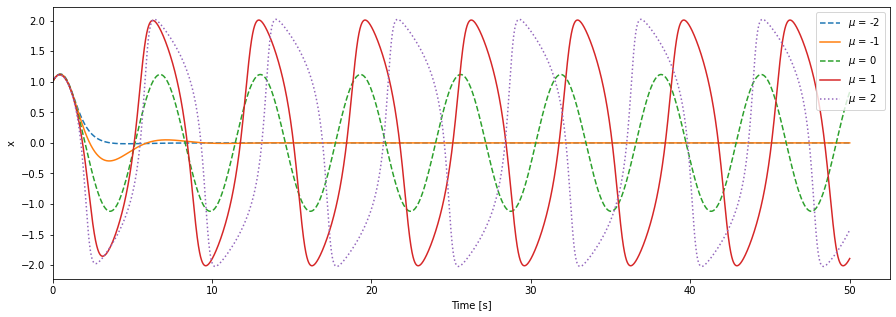

In [9]:
# Initial Conditions
plt.figure(figsize=(15,5))
linestyles = ['--','-','--', '-', 'dotted']
x0 = [1, 0.5] 
for index, a in enumerate(mu):
    x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[a], **integrator_keywords).y.T
    plt.plot(t, x[:,0], label='$\mu$ = {}'.format(a), ls=linestyles[index])
plt.xlabel('Time [s]')
plt.ylabel('x')
plt.xlim(left=0)
plt.legend()
plt.show()


We note a stable, periodic solution for control parameter $\mu > 0$. For $\mu < 0$, the system approaches a fixed point at $x = 0$. We can also see that the limiting periodic function depends on the value of the damping term $\mu$ i.e. period depends on mu.

## Dependence of Period on N.L Damping $\mu$
How does the periodicity depend on the value of mu?

In [10]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
dt = .001
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
mu = 1
def root(t, y, mu): # find zero crossings
    return y[0]
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], events=root, **integrator_keywords)

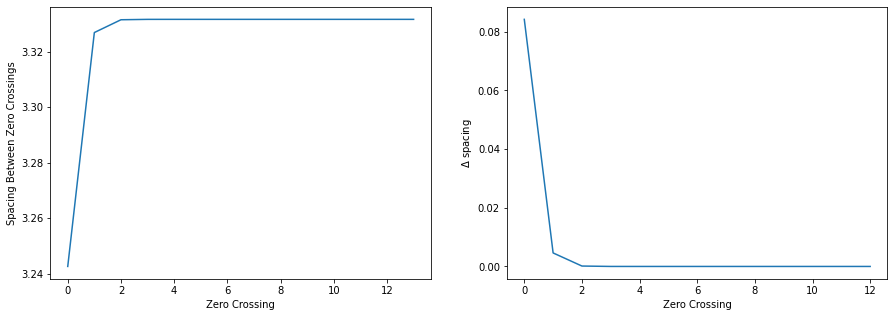

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
zeros = x.t_events[0]
spacing = np.diff(zeros)
ax[0].plot(spacing)
ax[0].set_xlabel('Zero Crossing')
ax[0].set_ylabel('Spacing Between Zero Crossings')
ax[1].plot(np.diff(spacing))
ax[1].set_xlabel('Zero Crossing')
ax[1].set_ylabel('$\Delta$ spacing')
plt.show()

We can see that the spacing between crossings reaches a fixed value (approx.) in the limit - this corresponds to behaviour in the limit cycle. Since zero crossings corresponding to half periods, the period of the limit cycle is given by twice the limiting spacing between zeros. We will take the average of the last 6 zero crossings to determine the period. 

In [12]:
period = 2 * np.mean(spacing[-6:]) # period is 2 * zero crossing
period

6.663286859338322

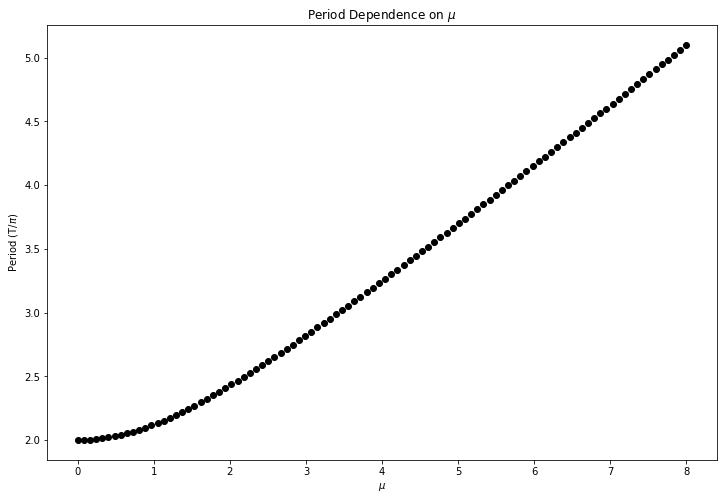

In [13]:
mus = np.linspace(0, 8, 100) 
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
dt = .001
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
def root(t, y, mu): # find zero crossings
    return y[0]
plt.figure(figsize=(12,8))
for mu in mus:
    x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], events=root, **integrator_keywords)
    zeros = x.t_events[0]
    spacing = np.diff(zeros) 
    period = 2 * np.mean(spacing[-6:])
    plt.scatter(mu, period/np.pi, color='k')
plt.ylabel('Period (T/$\pi$)')
plt.xlabel('$\mu$')
plt.title('Period Dependence on $\mu$')
plt.show()

#### We can clearly see here that at $\mu = 0$, we recover the simple harmonic oscillator with period $2 \pi$. As $\mu$ grows, the period of the limit cycle oscillations also grows.

## Phase Portraits
Look at 5 different initial conditions for each value of mu to see how these trajectories converge

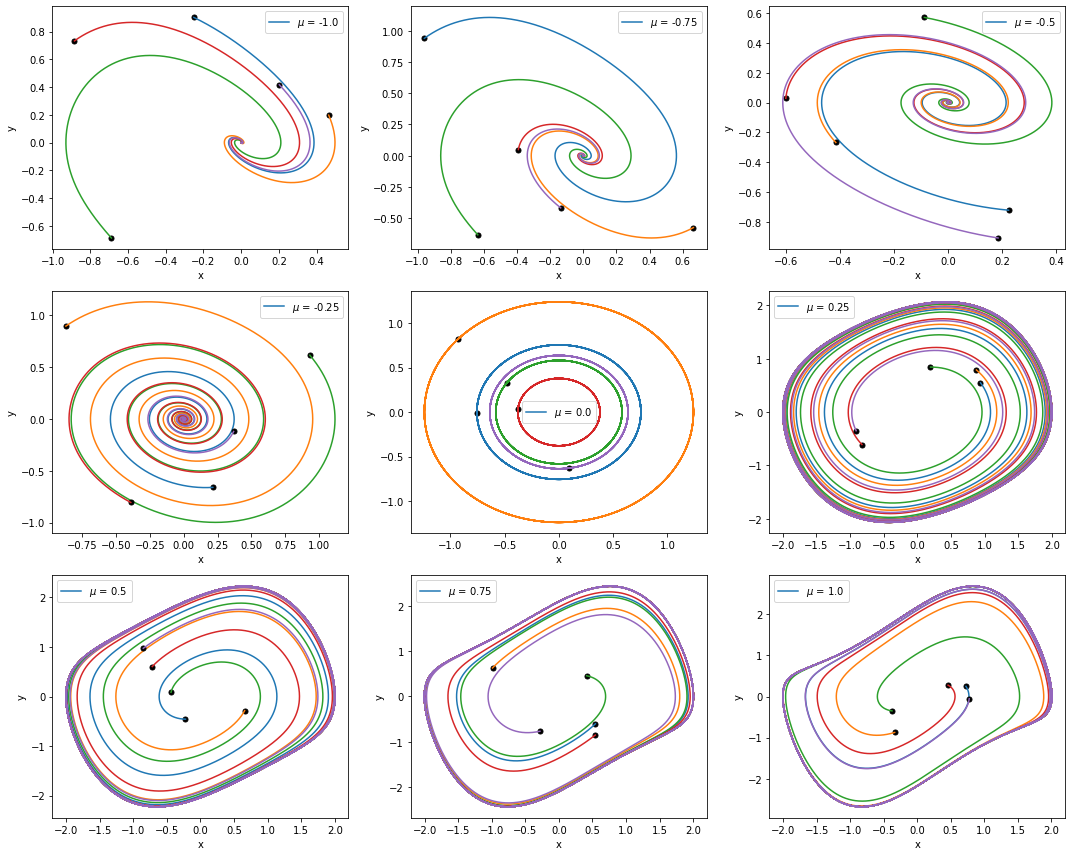

In [14]:
mu = np.linspace(-1, 1, 9)
dt = .001
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
fig, axs = plt.subplots(3, 3, figsize=(15,12))
for index, ax in enumerate(axs.ravel()):
    for i in range(5): # 5 different random initial conditions
        x0 = np.random.uniform(-1,1, size=(1,2))[0] # Between -1 and 1 uniform
        x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu[index]], **integrator_keywords).y.T
        ax.plot(x[0,0], x[0,1], marker='.', color='k', ms=10)
        ax.plot(x[:,0], x[:,1], label='$\mu$ = {}'.format(mu[index]) if i == 0 else "")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend()
fig.tight_layout()



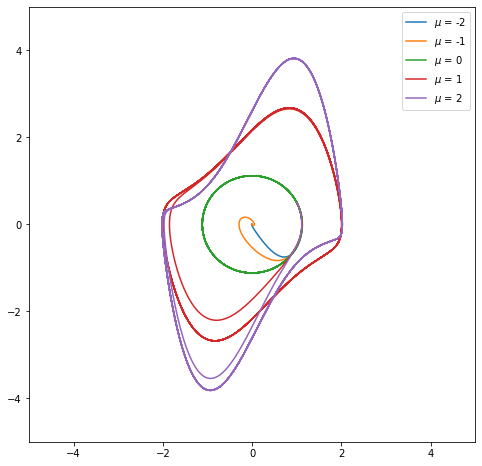

In [15]:
mus = [-2, -1, 0, 1, 2]
dt = .001
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
x0 = [1, 0.5]
plt.figure(figsize=(8,8))
for mu in mus:
    x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
    plt.plot(x[:,0], x[:,1], label='$\mu$ = {}'.format(mu))
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.legend()
plt.show()



We can see that as mu grows, the period of the limit cycle oscillations/orbits also grow.

### From the phase portrait, we go from an unstable limit cycle with a stable node @ origin for mu less than 0, to a stable limit cycle for mu greater than 0. At 0 we obtain a unit circle corresponding to a simple harmonic oscillator with trajetories remaining in a fixed orbit about the origin. As mu increases beyond 0, the  Therefore there are several regimes of interest:
- $\mu >> 1$ = 'relaxation oscilliations' or limit cycle behaviour "STRONGLY NONLINEAR LIMIT" - slow buildup followed by sudden discharge, followed by another slow buildup and so on - called 'relaxation' because the accumulated 'stress' that is built up, is suddenly discharged and thus relaxed. Thus there are two characteristic timescales that act sequentially - one corresponding to the slow buildup and one corresponding to the fast discharge.
- $\mu = 0$ = V.D.P oscillator reduces to a simple harmonic oscillator (undamped) with period $2\pi$ 'THE SHO REGIME'
- $\mu << 0$ = unstable limit cycle (with stable node at 0,0), node at the origin attracts all trajectories

# DP1: Generate Time Series __DP__ (Time series length, sampling freq, ic's)

If unsure about the sampling period, better to oversample then calculate the automutual information function of the over-sampled raw time series and use the lag at which mutual information is minimised as the sampling frequency to downsample to while ensuring that relevant dynamics are captured. In future, can set number of periods to be consistent across systems rather than number of points.

#### SHO Regime $\mu = 0$

In [16]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

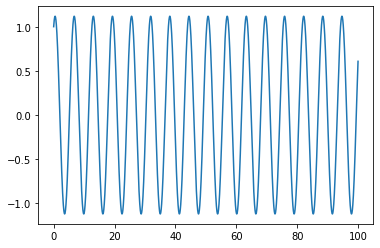

In [17]:
dt = 0.001
mu = 0
t = np.arange(0, 100, dt)
t_span = (t[0], t[-1])
x0 = [1, 0.5] # set ics 
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
plt.plot(t, x[:,0])

In [18]:
TS_VDP_SHO = [t, x]

Add Gaussian White Noise with variance eps

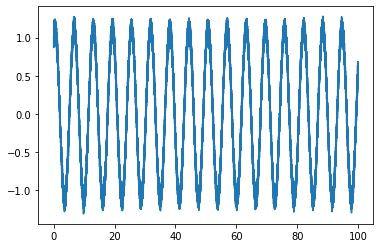

In [19]:
eps = 0.05
x = x + random.normal(scale=eps, size=x.shape)
plt.plot(t, x[:,0])

#### Collect TS Data for ensemble of uniformly distributed initial conditions given fixed mu

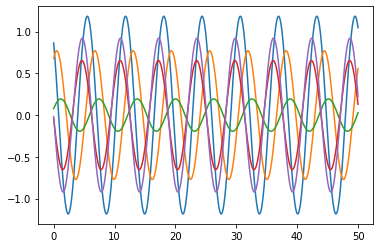

In [20]:
instances = 16
mu = 0
dt = .001
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
sols = np.zeros((instances, len(t)))
for i in range(instances):
    x0 = np.random.uniform(-1,1, size=(1,2))[0] # Between -1 and 1 uniform
    x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
    sols[i, :] = x[:,0]
[plt.plot(t, sols[i,:]) for i in range(5)]
plt.show()

### Heavily damped Regime $\mu = 6$ with limit cycle oscillations

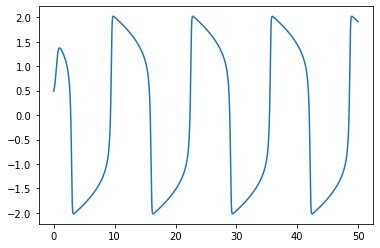

In [21]:
mu = 6
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
eps = 0
x = x + random.normal(scale=eps, size=x.shape)
plt.plot(t, x[:,0])


In [22]:
TS_VDP_HEAVYDAMP = [t,x]

## System 2 - Normal Form Hopf Bifurcation (Supercritical)

The Normal Form of the Hopf Bifurcation in XY coordinates is given by:
$$\dot{x} = - y + (\mu - x^2 - y^2)x$$
$$\dot{y} = x + (\mu - x^2 - y^2)y$$

Where $\mu$ is a control parameter. First, we will plot the time series as a function of mu. 

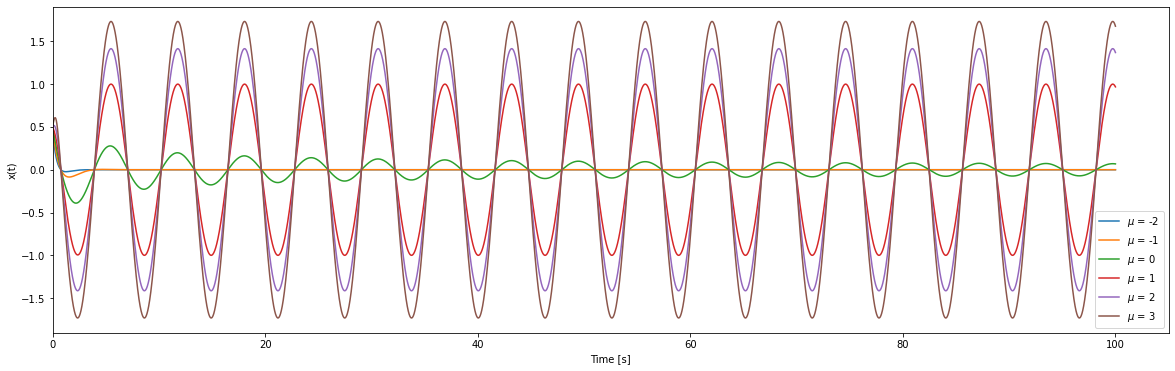

In [23]:
model = HopfNormalForm
mus = [-2, -1, 0, 1, 2, 3]
dt = 0.001
t = np.arange(0, 100, dt)
t_span = (t[0], t[-1])
x0 = [0.5, 0.5] # set ics 
plt.figure(figsize=(20,6))
for mu in mus:
    x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T
    plt.plot(t, x[:,0], label='$\mu$ = {}'.format(mu))
plt.xlim(left=0)
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('x(t)')
plt.show()

##### We can see that we likely approach a stable fixed point for mu less than 0. At mu = 0, we get periodic oscillations which grow with increasing mu. Let's ser how the period of oscillation depends on mu. We can also see that there is no dependence of the periodicity on the control parameter mu in the limit cycle regime.

## Phase Portrait

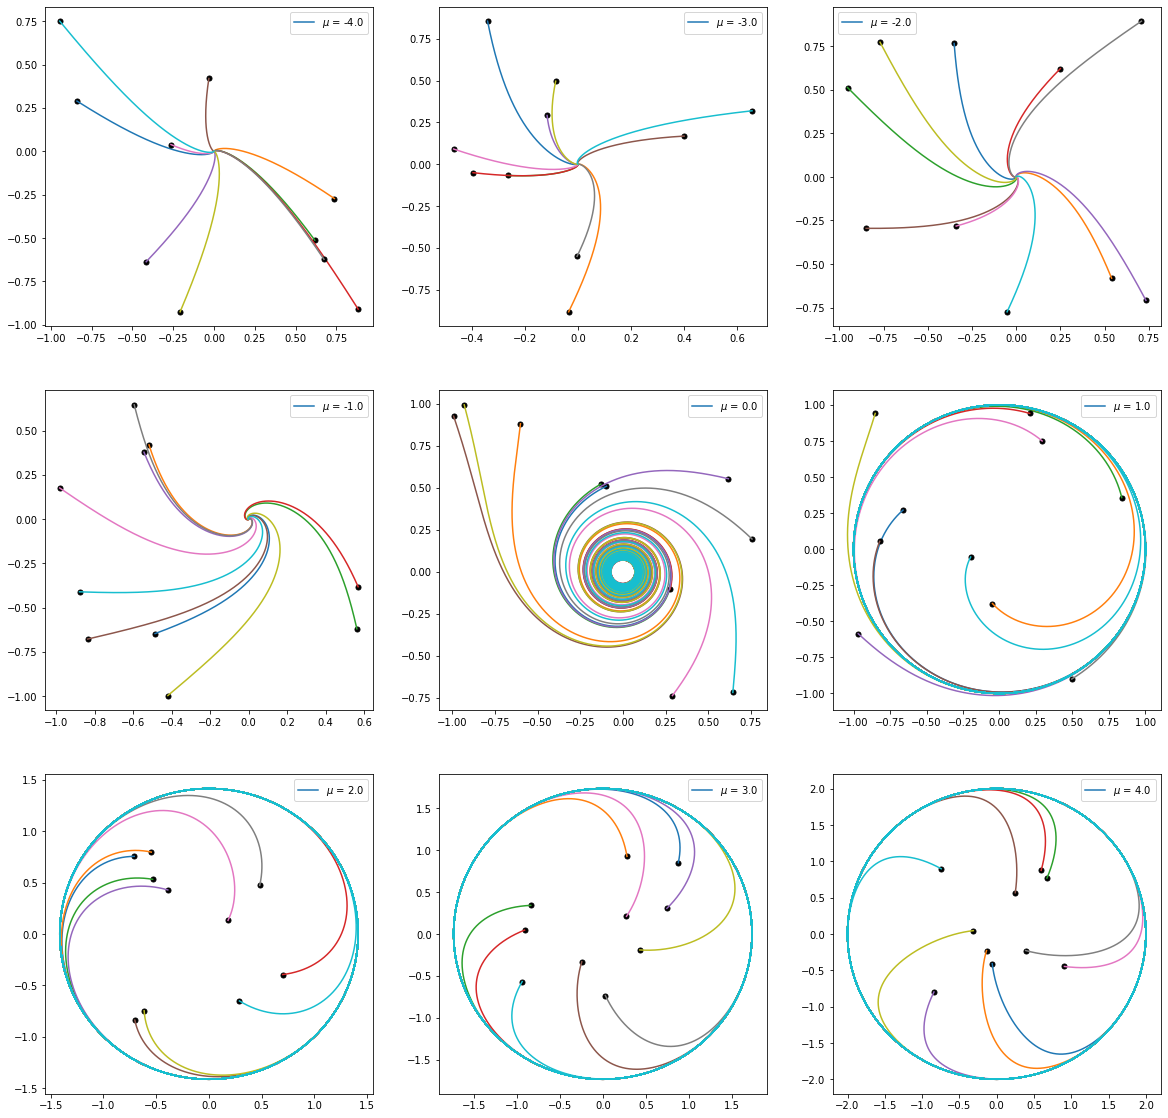

In [24]:
mu = np.linspace(-4,4, 9)
dt = 0.001
t = np.arange(0, 100, dt)
t_span = (t[0], t[-1])
fig, axs = plt.subplots(3, 3, figsize=(20,20))
for index, ax in enumerate(axs.ravel()):
    for i in range(10):
        x0 = np.random.uniform(-1, 1, size=(1,2))[0]
        x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu[index]], **integrator_keywords).y.T
        ax.plot(x[0,0], x[0,1], marker='.', color='k', ms=10)
        ax.plot(x[:,0], x[:,1], label='$\mu$ = {}'.format(mu[index]) if i == 0 else "")
    ax.legend()
plt.show()

We can see a supercritical Hopf bifurcation. For $\mu < 0$, all trajectories attract onto a stable fixed point at the origin. At $\mu \geq 0$, a stable circular limit cycle appears with radius $r = \sqrt{\mu}$ and angular frequency of $\omega = 1$. Size of limit cycle grows continuously from zero and increases proportional to $\sqrt{\mu - \mu_c}$ for mu near critical mu. We identify several regimes:
- $\mu < 0 $ = fixed point regime
- $\mu = 0$ = hopf bifurcation point
- $\mu >> 0$ = limit cycle regime

In [25]:
mu = 0
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[mu], **integrator_keywords).y.T

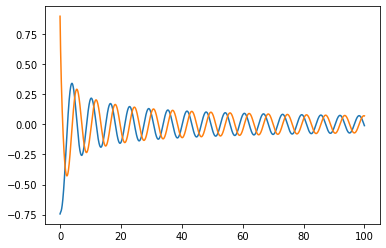

In [26]:
plt.plot(t, x)

In [27]:
TS_HOPF_BIF = [t,x]

## System 3 - Brownian Motion (Wiener Process)

The general form of a stochastic differential equation is:
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$
Brownian Motion (Wiener Process) is given by the following discretized equation:
$$W_j = W_{j-1} + dW_j$$
Where $W_0 = 0$, $j$ is the time index and $dW_j$ is an independent random variable of form $\sqrt{dt} \ \mathcal{N}(0,1)$.


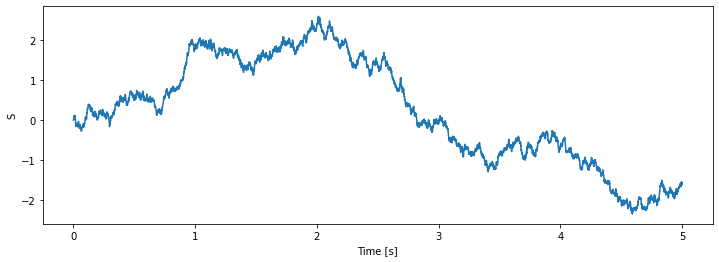

In [28]:
T = 5
N = 5000
t, x = Wiener.simulate(T, N, seed=87)
plt.figure(figsize=(12,4))
plt.xlabel('Time [s]')
plt.ylabel('S')
plt.plot(t, x)
plt.show()

We can clearly see that the time series is non-stationary.

In [29]:
TS_BROWNIAN = [t,x]

## System 4 - Chaotic Double Pendulum

In [30]:
model = DoublePendulum

In [31]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [32]:
l1 = 1
l2 = 1
m1 = 1
m2 = 1
g = 1
x0 = [np.pi/2, 0.01, 0.0, 0.0] # angular position of mass 1, angular position of mass 2, angular velcity of mass 1, ang. velocity of mass 2
dt = 0.001
t = np.arange(0, 200, dt)
t_span = (t[0], t[-1])
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[l1, l2, m1, m2, g], **integrator_keywords).y.T
# Convert to cartesian coordinates
x1 = l1 * np.sin(x[:,0])
y1 = -l1 * np.cos(x[:,0])
x2 = x1 + l2 * np.sin(x[:, 1])
y2 = y1 - l2 * np.cos(x[:, 1])

## Plot Time Series

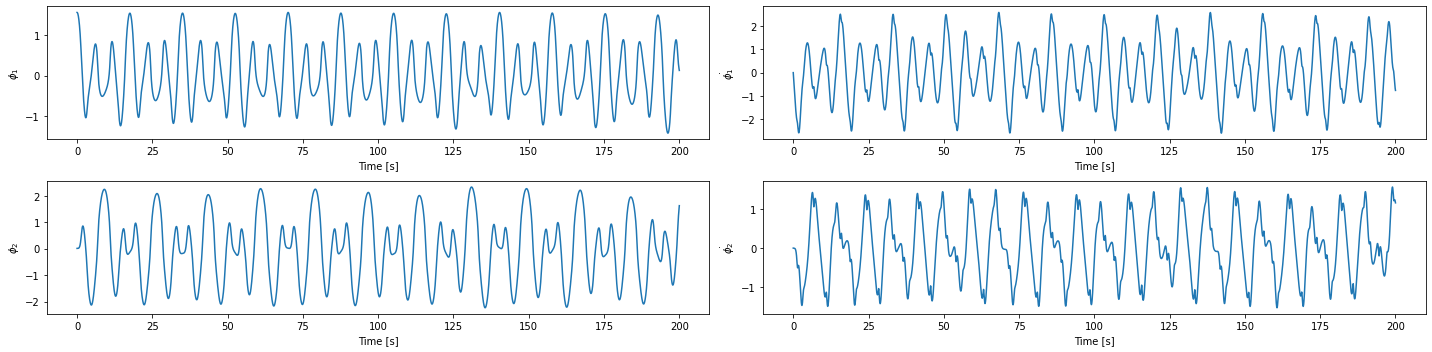

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(20,5))
ax[0,0].plot(t, x[:,0])
ax[0,0].set_xlabel('Time [s]')
ax[0,0].set_ylabel('$\phi_1$')
ax[1,0].plot(t, x[:,1])
ax[1,0].set_xlabel('Time [s]')
ax[1,0].set_ylabel('$\phi_2$')
ax[0,1].plot(t, x[:,2])
ax[0,1].set_xlabel('Time [s]')
ax[0,1].set_ylabel('$\dot{\phi_1}$')
ax[1,1].plot(t, x[:,3])
ax[1,1].set_xlabel('Time [s]')
ax[1,1].set_ylabel('$\dot{\phi_2}$')
plt.tight_layout()
plt.show()

In [34]:
TS_DOUBPEND = [t,x]

## Plot Phase Portrait of End of Pendulum

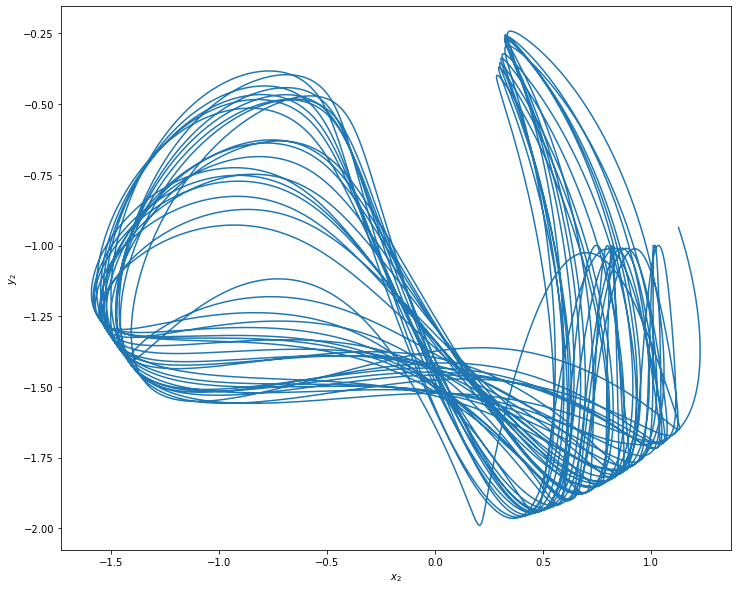

In [35]:
plt.figure(figsize=(12,10))
plt.plot(x2, y2)
plt.xlabel('$x_2$')
plt.ylabel('$y_2$')
plt.show()

## Demonstrating Chaos
Run two realisations of the double pendulum with same parameters but slightly different initial conditions and compare their time-series and phase portraits. We will perturb the starting angle of the first arm slightly in the second instance. 

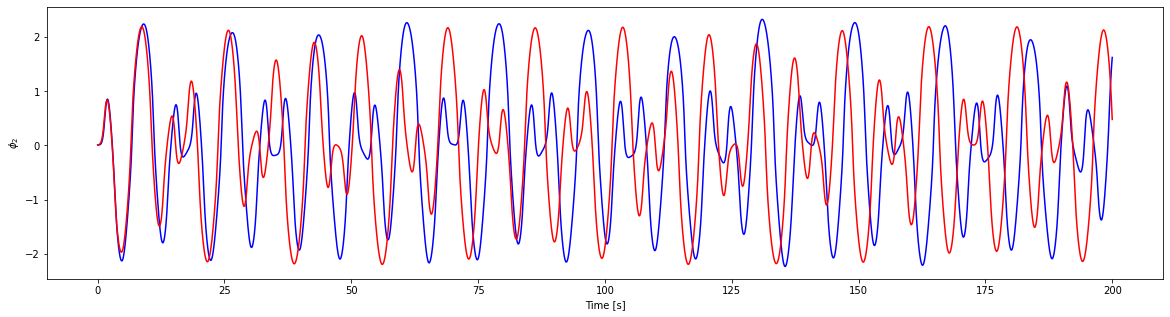

In [36]:
x0 = [np.pi/2, 0.01, 0.0, 0.0]
x1 = [np.pi/2.2, 0.01, 0.0, 0.0] # perturb initial conditions on 2nd realisation
x0_sol = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[l1, l2, m1, m2, g], **integrator_keywords).y.T
x1_sol = solve_ivp(model.rhs, t_span, x1, t_eval=t, args=[l1, l2, m1, m2, g], **integrator_keywords).y.T
plt.figure(figsize=(20, 5))
plt.plot(t, x0_sol[:,1], color='blue')
plt.plot(t, x1_sol[:,1], color='red')
plt.xlabel('Time [s]')
plt.ylabel('$\phi_2$')
plt.show()

We see that while the angle of the second arms of the two pendula remain in phase for the first few seconds, they quickly diverge.

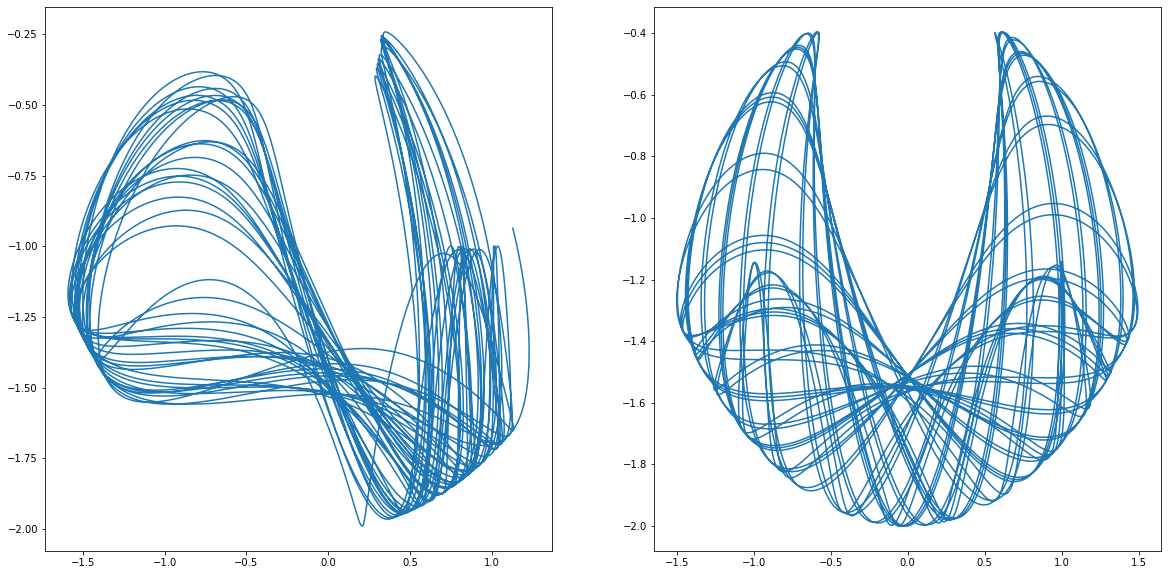

In [37]:
x1_sol_0 = l1 * np.sin(x0_sol[:,0])
y1_sol_0 = -l1 * np.cos(x0_sol[:,0])
x2_sol_0 = x1_sol_0 + l2 * np.sin(x0_sol[:, 1])
y2_sol_0 = y1_sol_0 - l2 * np.cos(x0_sol[:, 1])

x1_sol_1 = l1 * np.sin(x1_sol[:,0])
y1_sol_1 = -l1 * np.cos(x1_sol[:,0])
x2_sol_1 = x1_sol_1 + l2 * np.sin(x1_sol[:, 1])
y2_sol_1 = y1_sol_1 - l2 * np.cos(x1_sol[:, 1])
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(x2_sol_0, y2_sol_0)
ax[1].plot(x2_sol_1, y2_sol_1)
plt.show()

## System 5 - Damped, Driven Pendulum

The damped driven Pendulum (DDP) has equations of motion given by the following:
$$\ddot{\phi} + 2\beta \dot{\phi} + \omega_{0}^2 \sin{\phi} = \gamma \omega_0^2 \cos{\omega t}$$
Where $\omega_0$ is the natural frequency of the pendulum, $\beta$ is the damping constant, $\gamma$ is the drive strength i.e. ratio of drive amplitude to the pendulum weight mg. 

In [38]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [39]:
omega = 2 * np.pi  # set drive frequency so that drive period 2pi/omega = 1
omega_0 = 1.5 * omega # start system fairly close to resonance
beta = omega_0/4
gamma = 1.105 # Start with weak damping
model = DampedDrivenPendulum
x0 = [-np.pi/2,0]
dt = 0.001
t = np.arange(0, 100, dt)
t_span = (t[0], t[-1])
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[gamma, omega_0, omega, beta], **integrator_keywords).y.T


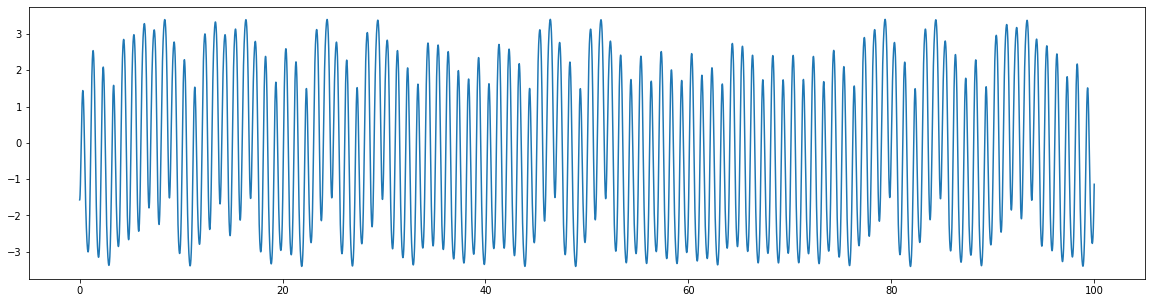

In [40]:
plt.figure(figsize=(20,5))
plt.plot(t, x[:,0])
plt.show()

In [41]:
TS_DDP_CHAOTIC = [t,x]

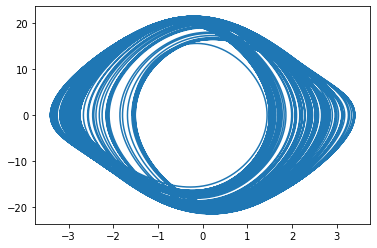

In [42]:
plt.plot(x[:,0], x[:,1])

In the linear regime where the driving strength $\gamma << 1$, the initial transients die out and the motion approaches a unique attractor in which the pendulum oscillates with the same period as the driver. We go from the linear regime with its purely sinusoidal response, to the nearly linear regime, with the addition of harmonics and period doubling cascade to chaos with increasing gamma.

Regimes: 
- $\gamma << 1$ = Linear Regime

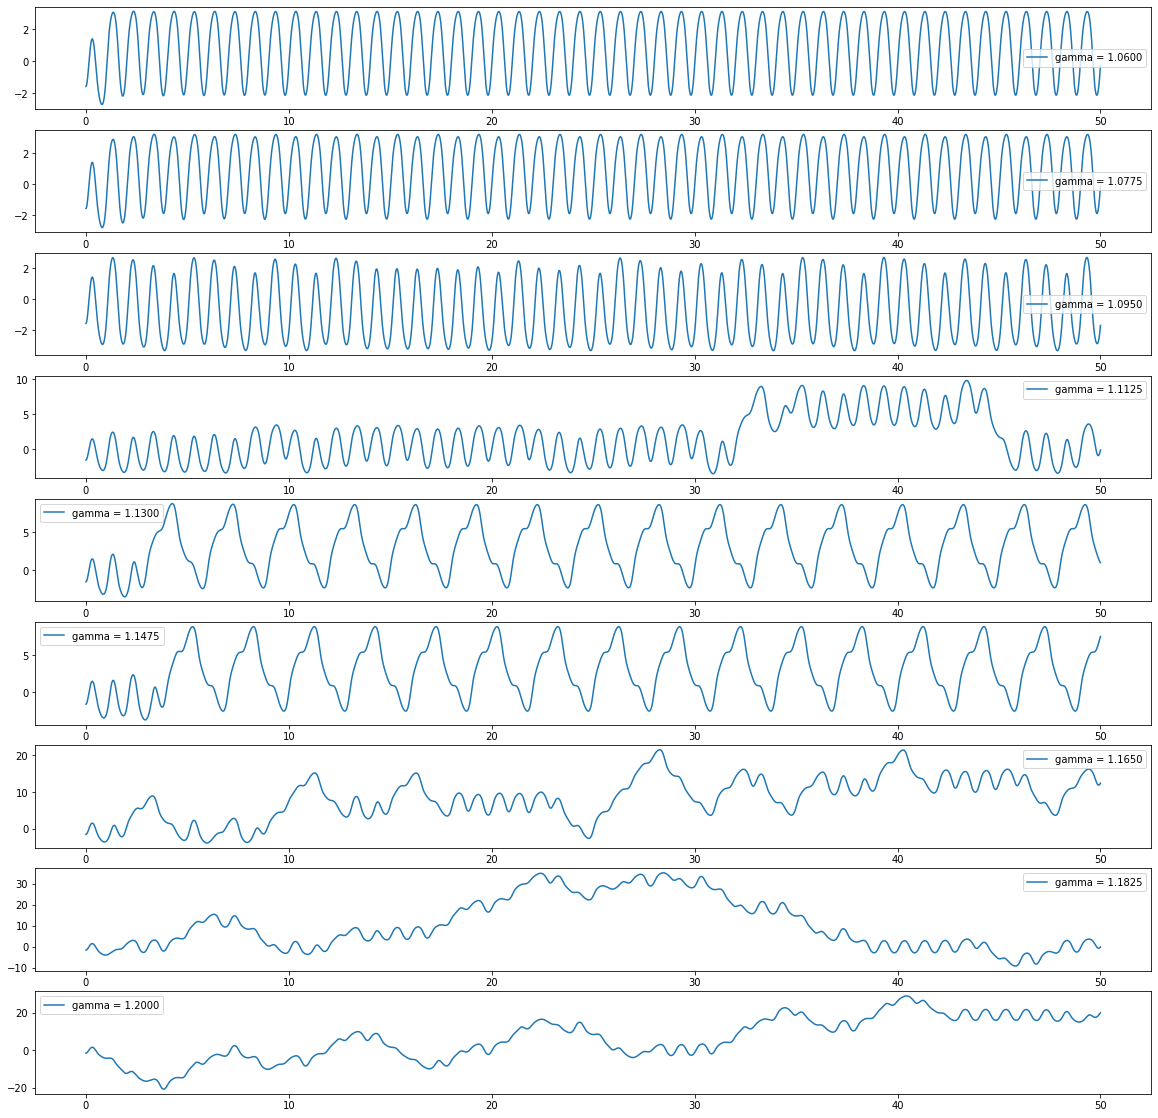

In [43]:
omega = 2 * np.pi  # set drive frequency so that drive period 2pi/omega = 1
omega_0 = 1.5 * omega # start system fairly close to resonance
beta = omega_0/4
model = DampedDrivenPendulum
x0 = [-np.pi/2,0]
gamma = np.linspace(1.06, 1.2, 9)
dt = 0.001
eps = 0
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
fig, axs = plt.subplots(9,1, figsize=(20,20))
for index, ax in enumerate(axs.ravel()):
    x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[gamma[index], omega_0, omega, beta], **integrator_keywords).y.T
    x += random.normal(scale=eps, size=x.shape)
    ax.plot(t, x[:,0], label='gamma = {:.4f}'.format(gamma[index]))
    #ax.plot(x[:,0], x[:,1], label='gamma = {:.4f}'.format(gamma[index]))
    ax.legend()

## System 5 - Strange Attractor Lorenz System

The Lorenz System is a simplified model describing the convective motion of the atmosphere heated by the ground below and is given by the following:
$$\frac{dx}{dt} = \sigma (y-x)$$
$$\frac{dx}{dt} = -xz + rx - y$$
$$\frac{dz}{dt} = xy - bz$$
Where $x$ describes the speed of rotation, positive representing clockwise and negative representing counter-clockwise. The variable $y$ is the temperature difference between rising and falling fluids and $z$ is the distortion from linearity of the vertical temperature profile. The parameters $r$ and $\sigma$ are proprtional to the Rayleigh number and Pramdtl number respectively while $b$ is the aspect ratio of the convection cylinders. Typical values for the parameters are $\sigma = 10$, $r = 28$ and $b = 8/3$.

In [44]:
sigma = 10
r = 28
b = 8/3
x0 = [0,1,0]
model = Lorenz

In [45]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [46]:
dt = 0.001
eps = 0
t = np.arange(0, 50, dt)
t_span = (t[0], t[-1])
x = solve_ivp(model.rhs, t_span, x0, t_eval=t, args=[sigma, r, b], **integrator_keywords).y.T
x += random.normal(scale=eps, size=x.shape) # add noise

Text(0, 0.5, 'X')

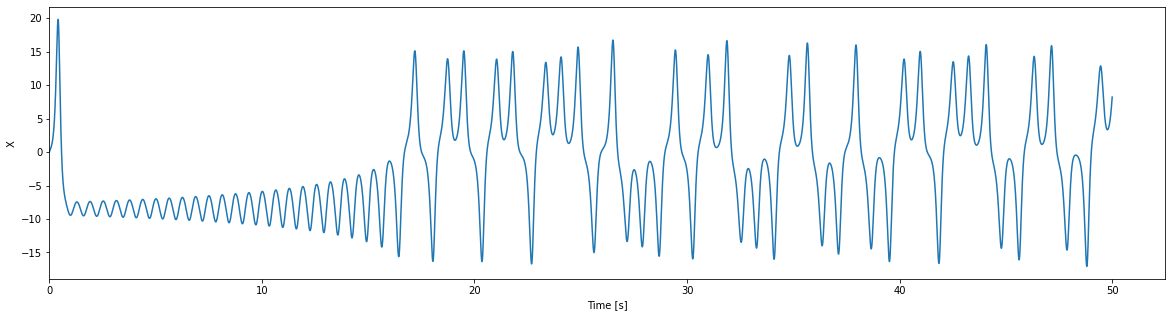

In [47]:
plt.figure(figsize=(20,5))
plt.plot(t, x[:,0])
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('X')

We see that after the initial transient, the system settles into aperiodic oscillations.

In [48]:
TS_Lorenz_CHAOTIC = [t,x]

# System 6 - Lag 1 Autoregressive AR(1)

In general, an autoregressive model of order $p$ is defined as:
$$X_t = c + \sum_{i=1}^{p} \phi_i X_{t-1} + \epsilon_{t}$$

Where $\epsilon_t$ is Gaussian White Noise, $\phi_1, ..., \phi_p$ are the model parameters and $c$ is a constant. Thus, the output variable depends linearly on its own previous values and on a stochastic term (epsilon). We will set the contant $c = 0$.

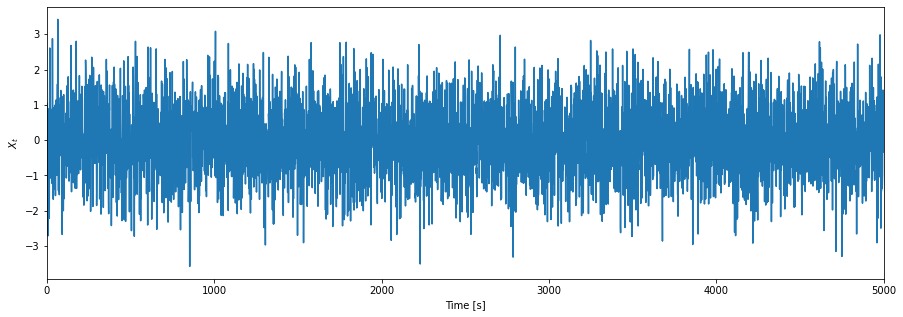

In [49]:
phi = 0.1
N = 5000
x = AR1.simulate(phi, N)
t = np.arange(0, N, 1)
plt.figure(figsize=(15,5))
plt.plot(t, x)
plt.xlim(left=0, right=N)
plt.xlabel('Time [s]')
plt.ylabel('$X_t$')
plt.show()

In [50]:
TS_AR1 = [t,x]

# __DP2__ - Feature Extraction (Catch22)

In [51]:
# Time series data to test
#TS_VDP_SHO -> SHO regime
#TS_VDP_HEAVYDAMP -> limit cycle 
#TS_HOPF_BIF -> at hopf bifurcation point
#TS_BROWNIAN
#TS_DOUBPEND
#TS_DDP_CHAOTIC -> chaotic regime 
#TS_Lorenz_CHAOTIC -> chaotic regime
#TS_AR1

#### Plot each of the univariate time series

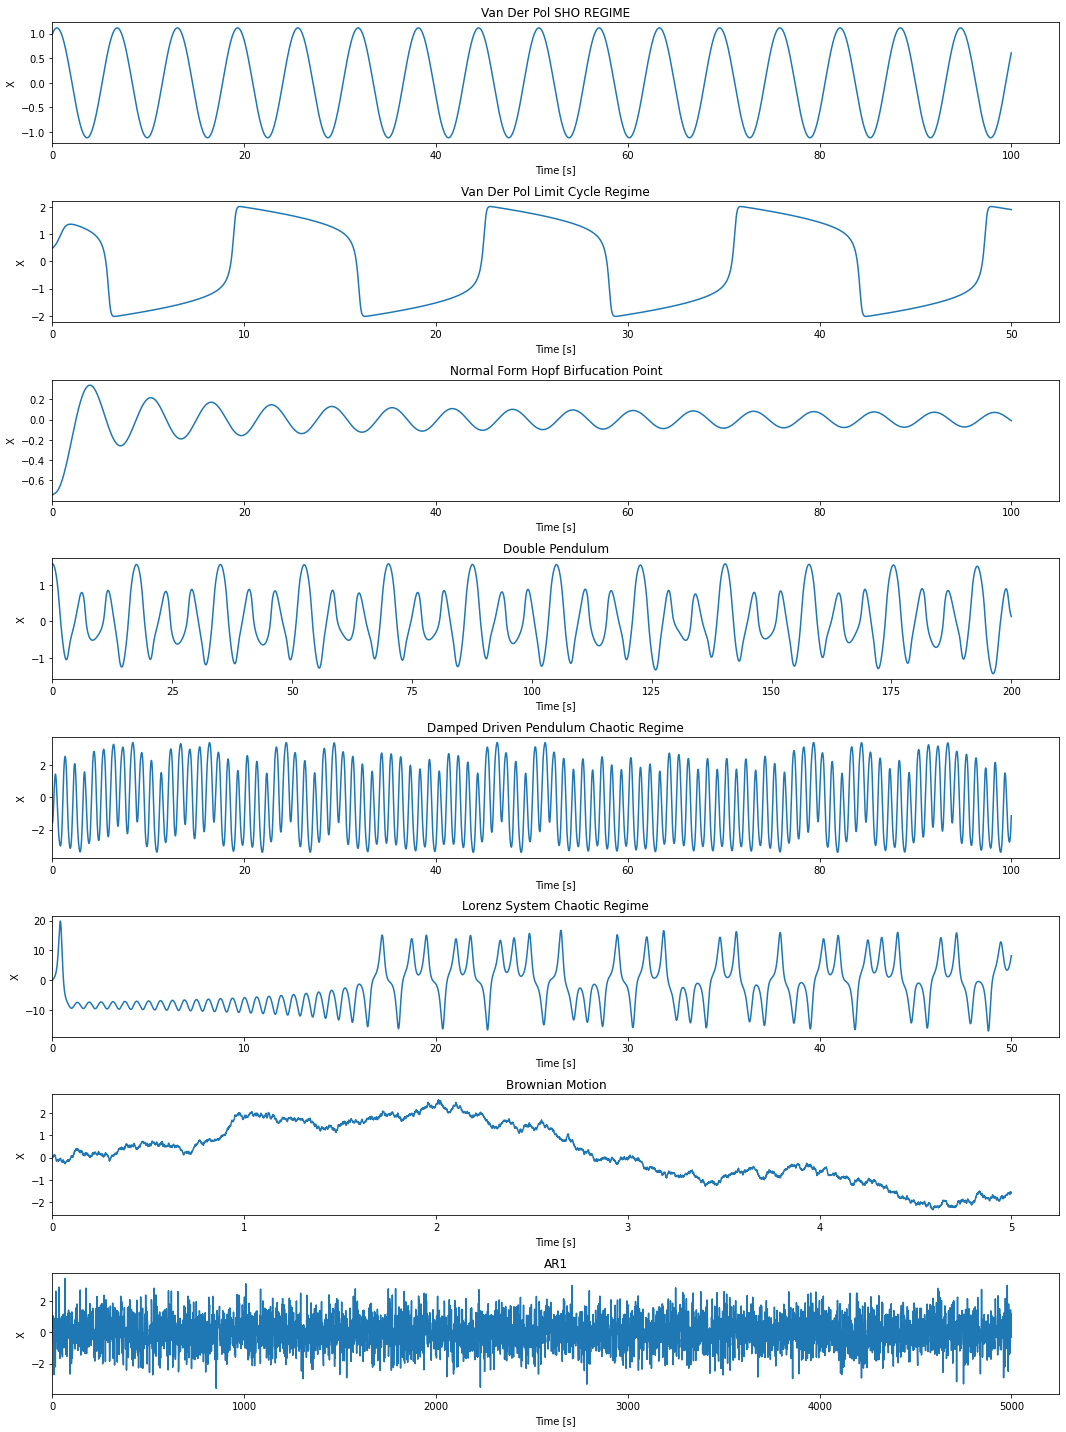

In [66]:
tsData = [TS_VDP_SHO, TS_VDP_HEAVYDAMP, TS_HOPF_BIF, TS_DOUBPEND, TS_DDP_CHAOTIC, TS_Lorenz_CHAOTIC]
names = ['Van Der Pol SHO REGIME', 'Van Der Pol Limit Cycle Regime', 'Normal Form Hopf Birfucation Point', 'Double Pendulum', 'Damped Driven Pendulum Chaotic Regime', 
'Lorenz System Chaotic Regime', 'Brownian Motion', 'AR1']
fig, axes = plt.subplots(8, 1, figsize=(15, 20))
for index, ax in enumerate(axes.ravel()):
    if index == 6:
        ax.plot(TS_BROWNIAN[0], TS_BROWNIAN[1])
    elif index == 7:
        ax.plot(TS_AR1[0], TS_AR1[1])
    else:
        ax.plot(tsData[index][0], tsData[index][1][:,0])
    ax.set_title(names[index])
    ax.set_xlim(left=0)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('X')
fig.tight_layout()



#### Extract Features - Plot Feature Matrix?

In [53]:
catch22_features = [
        'DN_HistogramMode_5',
        'DN_HistogramMode_10',
        'CO_f1ecac',
        'CO_FirstMin_ac',
        'CO_HistogramAMI_even_2_5',
        'CO_trev_1_num',
        'MD_hrv_classic_pnn40',
        'SB_BinaryStats_mean_longstretch1',
        'SB_TransitionMatrix_3ac_sumdiagcov',
        'PD_PeriodicityWang_th0_01',
        'CO_Embed2_Dist_tau_d_expfit_meandiff',
        'IN_AutoMutualInfoStats_40_gaussian_fmmi',
        'FC_LocalSimple_mean1_tauresrat',
        'DN_OutlierInclude_p_001_mdrmd',
        'DN_OutlierInclude_n_001_mdrmd',
        'SP_Summaries_welch_rect_area_5_1',
        'SB_BinaryStats_diff_longstretch0',
        'SB_MotifThree_quantile_hh',
        'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
        'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
        'SP_Summaries_welch_rect_centroid',
        'FC_LocalSimple_mean3_stderr']

In [67]:
FEATURES_VDP_SHO = catch22.catch22_all(TS_VDP_SHO[1][:,0])['values'] # extract just the values part of the dictionary
FEATURES_VDP_HEAVYDAMP = catch22.catch22_all(TS_VDP_HEAVYDAMP[1][:,0])['values']
FEATURES_HOPF_BIF = catch22.catch22_all(TS_HOPF_BIF[1][:,0])['values']
FEATURES_DOUBPEND = catch22.catch22_all(TS_DOUBPEND[1][:,0])['values']
FEATURES_DDP_CHAOTIC = catch22.catch22_all(TS_DDP_CHAOTIC[1][:,0])['values']
FEATURES_LORENZ_CHAOTIC = catch22.catch22_all(TS_Lorenz_CHAOTIC[1][:,0])['values']
FEATURES_BROWNIAN = catch22.catch22_all(TS_BROWNIAN[1])['values']
FEATURES_AR1 = catch22.catch22_all(TS_AR1[1])['values']
FEATURES_LIST = [FEATURES_VDP_SHO, FEATURES_VDP_HEAVYDAMP, FEATURES_HOPF_BIF, FEATURES_DOUBPEND, FEATURES_DDP_CHAOTIC, 
            FEATURES_LORENZ_CHAOTIC, FEATURES_BROWNIAN, FEATURES_AR1]

## ** Standardise Features

In [68]:
FEATURES_ARRAY = np.vstack([FEATURES_LIST[i] for i in range(len(FEATURES_LIST))])
normalized_features = StandardScaler().fit_transform(FEATURES_ARRAY)

In [69]:
normalized_features.shape

(8, 22)

# __DP3__ - DIMENSIONALITY REDUCTION (PCA)

## ** APPLY STOCK STANDARD PCA ($\mathcal{R}^{22} \rightarrow \mathcal{R}^2$)

In [70]:
pca_reducer = PCA(n_components=2)
embedding = pca_reducer.fit_transform(normalized_features)

In [71]:
embedding.shape

(8, 2)

## Visualise Embeddings in $\mathcal{R}^2$

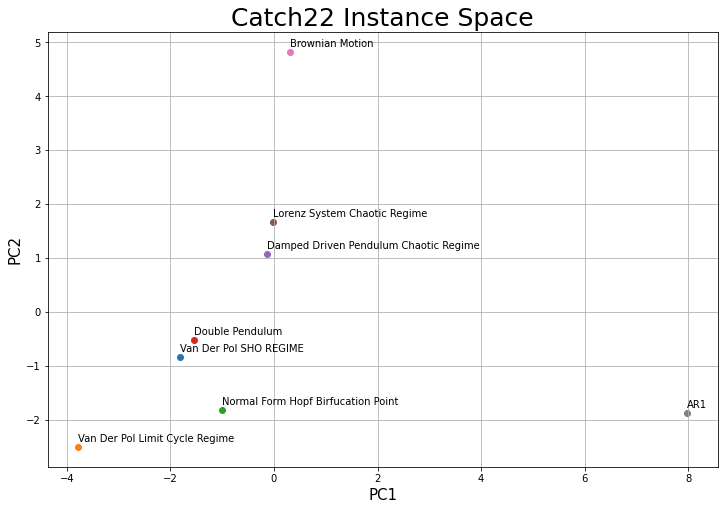

In [72]:
plt.figure(figsize=(12, 8))
for i in range(embedding.shape[0]):
    plt.scatter(embedding[i,0], embedding[i,1])
    plt.annotate(names[i], (embedding[i,0], embedding[i,1]+0.1))
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Catch22 Instance Space', fontsize=25)
plt.grid()
plt.show()

There is some clustering between the Van Der Pol and Double Pendulum in the SHO regimes. Also, both chaotic regimes in the DDP and Lorenz system are relatively close to one another in the instance space. Thus, at first glance, it appears as though systems with qualitiatively similar dynamics are being clustered (as expected) in this lower dimensional space. Since PCA constructs dimensions with linear combinations of the extracted features, it is therefore highly interpretable which is ideal for understanding how algorithm performance varies as a function of these features.

To make our analysis of this instance space more rigorous, it would be prudent to compute similarity scores between instances and use this to assess our instance space by ensuring topological information is preserved (i.e. distances are correlated with similarity).

##### Find most important features in PC1 and PC2

In [60]:
most_informative = [np.abs(pca_reducer.components_[i]).argmax() for i in range(2)] # get index of the most important feature for each PC
pca_reducer.components_

array([[ 0.15378918,  0.0721898 , -0.23715229, -0.22559454, -0.24603246,
        -0.28470842,  0.28842821, -0.24409214, -0.03258336, -0.22475271,
        -0.13771722, -0.28470663, -0.08868782,  0.02263237,  0.01019822,
        -0.28474947, -0.21627035,  0.28837763, -0.21279779,  0.00106115,
         0.28493566,  0.28647952],
       [-0.13417025,  0.27193462, -0.14627111, -0.15886168,  0.1985734 ,
         0.13732097, -0.10410183, -0.15971529,  0.37318224, -0.24065003,
        -0.10513284,  0.13733259, -0.29855319,  0.03223137,  0.24089539,
         0.13708709, -0.27822002, -0.11675499, -0.24023781, -0.43458424,
        -0.13680614, -0.12792351]])

In [61]:
print('Most informative featue in PC1: ' ,catch22_features[most_informative[0]])
print('Most informative featue in PC2: ' ,catch22_features[most_informative[1]])

Most informative featue in PC1:  MD_hrv_classic_pnn40
Most informative featue in PC2:  SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1


## Analyse Instance Space

##### Examine performance of PCA using Scree-Plot of the Variance Explained versus the number of Principle Components

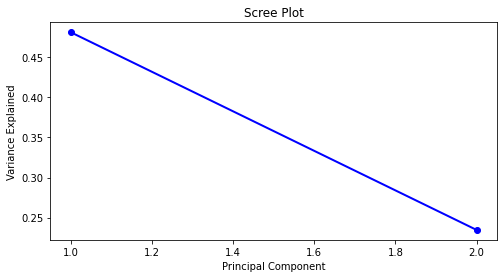

In [62]:
pc_values = np.arange(pca_reducer.n_components_) +1
plt.figure(figsize=(8,4))
plt.plot(pc_values, pca_reducer.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


In [63]:
print('Variance Captured by first 2 PCs: {:.2f}%'.format(100*sum(pca_reducer.explained_variance_ratio_[:2])))

Variance Captured by first 2 PCs: 71.60%


### Distribution of Feature Values Across Instance Space
Select an example feature and examine how it varies across the instance space using a heat map or similar. We will focus on the feature 'SB_TransitionMatrix_3ac_sumdiagcov', which is the feature with the highest weighting in PC2. The feature values have been normalized as they are very small (also, it will make visualisation clearer).

In [64]:
raw_transitionMatrix = FEATURES_ARRAY[:,8]
sb_transitionMatrix_normalized = (raw_transitionMatrix - np.min(raw_transitionMatrix))/(np.max(raw_transitionMatrix - np.min(raw_transitionMatrix)))

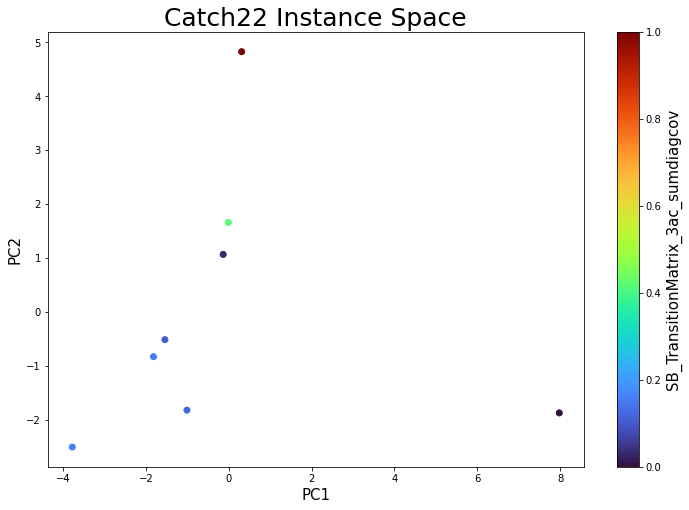

In [65]:
test_val = np.arange(0, 9, 1)
plt.figure(figsize=(12, 8))
plt.scatter(embedding[:,0], embedding[:,1], c=sb_transitionMatrix_normalized, cmap="turbo")
cbar = plt.colorbar()
cbar.set_label(label='SB_TransitionMatrix_3ac_sumdiagcov', size=15)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Catch22 Instance Space', fontsize=25)
plt.show()

The feature `SB_TransitionMatrix_3ac_sumdiagcov` has the highest weighting in PC2. This is reflected in the variation of the feature value (normalized) in instance space which increases with PC2 - thus as we go from bottom to top, the value of this feature increases. 

##### Compute Similarity Scores b/w instances and use to assess the embedding 

# __DP4__ - Algorithm Evaluation Methods